In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import griddata
from tqdm import tqdm
import matplotlib.pyplot as plt


# Function to generate polynomial features up to a given order for two-dimensional input
def polynomial_features(x, order=1):
    n = x.size(0)
    features = [torch.ones(n)]
    for i in range(1, order + 1):
        for j in range(i + 1):
            features.append((x[:, 0]**(i-j)) * (x[:, 1]**j))
    return torch.cat([f.unsqueeze(1) for f in features], dim=1)


# Tri-cube weight function
def tri_cube(u):
    return torch.where(u < 1, (1 - u**3)**3, torch.zeros_like(u))


# Calculate weights for all points based on a fitting point and bandwidth
def calculate_weights(data_points, fitting_point, bandwidth):
    if fitting_point.dim() == 1:
        fitting_point = fitting_point.unsqueeze(0)
    distances = torch.sqrt(torch.sum((data_points - fitting_point)**2, axis=1))
    scaled_distances = distances / bandwidth
    weights = tri_cube(scaled_distances)
    return weights


# Perform weighted least squares regression (optimized)
def weighted_least_squares(X, y, weights):
    # Assume X is n x m and weights is n x 1
    weighted_X = X * weights.unsqueeze(1)  # element-wise multiplication to weight each row
    XTWX = weighted_X.T @ X  # This replaces the need for explicitly creating W
    XTWy = weighted_X.T @ y
    beta = torch.linalg.pinv(XTWX) @ XTWy
    return beta.squeeze()


# Calculate adaptive bandwidth based on the percentile of distances
def adaptive_bandwidth(data_points, fitting_point, percentile=30):
    if fitting_point.dim() == 1:
        fitting_point = fitting_point.unsqueeze(0)
    distances = torch.sqrt(torch.sum((data_points - fitting_point)**2, axis=1))
    return torch.quantile(distances, percentile / 100.0)


def process_data(data, covariates, response):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data[covariates] = scaler.fit_transform(data[covariates])
    
    features = torch.tensor(data[covariates].values, dtype=torch.float32)
    target = torch.tensor(data[response].values, dtype=torch.float32)
    
    return features, target, scaler


def fit_model(features, target, n_fitting_points=24):
    x = torch.linspace(-1, 1, n_fitting_points)
    y = torch.linspace(-1, 1, n_fitting_points)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    fitting_points = torch.column_stack([X.ravel(), Y.ravel()])
    
    X_poly_base = polynomial_features(features)
    
    coefficients = torch.zeros(len(fitting_points), X_poly_base.size(1), dtype=torch.float32)
    predicted_values = torch.zeros(len(fitting_points), dtype=torch.float32)
    
    for i, fp in enumerate(tqdm(fitting_points, desc="Fitting Points")):
        bandwidth = adaptive_bandwidth(features, fp, percentile=30)
        weights = calculate_weights(features, fp, bandwidth)
        X_poly = polynomial_features(fp.clone().detach().unsqueeze(0))
        beta = weighted_least_squares(X_poly_base, target, weights)
        coefficients[i] = beta
        predicted_values[i] = torch.matmul(X_poly, beta)
    
    return fitting_points, predicted_values


def plot_results(n_grid_points, fitting_points, predicted_values, scaler, filename, plane_zero=False):
    fitting_points = fitting_points.cpu()  # Transfer to CPU
    predicted_values = predicted_values.cpu()  # Transfer to CPU
    
    grid_y, grid_x = np.meshgrid(np.linspace(-1, 1, n_grid_points), np.linspace(-1, 1, n_grid_points))
    grid_z = griddata(fitting_points.numpy(), predicted_values.numpy(), (grid_x, grid_y), method='cubic')
    
    original_grid_x, original_grid_y = scaler.inverse_transform(np.column_stack([grid_x.ravel(), grid_y.ravel()])).T
    original_grid_x = original_grid_x.reshape(grid_x.shape)
    original_grid_y = original_grid_y.reshape(grid_y.shape)
    
    fig = plt.figure(figsize=(6, 9), dpi=300)
    ax = fig.add_subplot(111, projection='3d')
    surface = ax.plot_surface(original_grid_x, original_grid_y, grid_z, cmap='plasma', edgecolor='k', linewidth=0.5)
    contours = ax.contourf(original_grid_x, original_grid_y, grid_z, zdir='z', offset=np.min(grid_z), cmap='plasma', alpha=0.7)
    contours = ax.contourf(original_grid_x, original_grid_y, grid_z, zdir='x', offset=np.min(original_grid_x), cmap='plasma', alpha=0.7)
    contours = ax.contourf(original_grid_x, original_grid_y, grid_z, zdir='y', offset=np.max(original_grid_y), cmap='plasma', alpha=0.7)
    
    # Add a plane for price zero
    if plane_zero:
        ax.plot_surface(original_grid_x, original_grid_y, np.zeros_like(original_grid_x), color='red', alpha=0.8, rstride=100, cstride=100)
    
    cbar = fig.colorbar(surface, orientation='horizontal', shrink=0.5, aspect=40, pad=0.05, anchor=(0.5, 1.2))
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.set_xlabel('Forecasted WP penetration (%)')
    ax.set_ylabel('Hour of the day')
    ax.set_zlabel('Price (EUR/MWh)')
    ax.set_zlim(-80, 250)
    plt.tight_layout()
    fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.85)
    if filename is not None:
        plt.savefig(filename, format='png', dpi=300, bbox_inches='tight', pad_inches=0.2)
    plt.show()

Fitting Points: 100%|██████████| 576/576 [00:01<00:00, 539.86it/s]
/var/folders/wy/btpv_9l163n19ww7jjqf7d6c0000gn/T/ipykernel_16880/3205554395.py:71: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


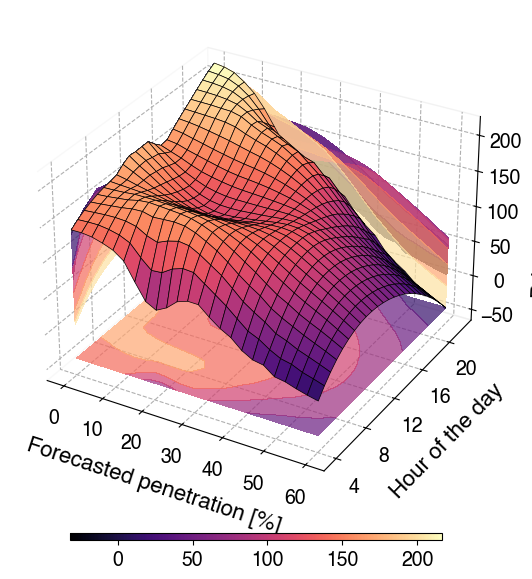

In [2]:
#from utils_mean import *
import matplotlib as mpl
import matplotlib.colors as mcolors

# Set plot aesthetics
mpl.rcParams.update({
    'font.family': 'Helvetica',  # Use Helvetica for clarity
    'axes.labelsize': 16,        # Larger axis labels
    'axes.titlesize': 16,        # Title font size
    'xtick.labelsize': 14,       # X-axis tick label size
    'ytick.labelsize': 14,       # Y-axis tick label size
    'legend.fontsize': 14,       # Legend font size
    'axes.grid': True,           # Enable grid
    'grid.alpha': 0.1,           # Subtle grid lines
    'grid.linestyle': '--',      # Dashed grid lines for a softer look
    'figure.dpi': 300,           # High DPI for high-quality figure
    'savefig.dpi': 300           # High DPI for saving the figure
})

df = pd.read_csv('data/thesis_data.csv')
df = df[df['solar_penetration'] != 0] # filtering for daytime
df = df[df['solar_penetration'] < 60] # check

# Define covariates and response
covariates = ['solar_penetration', 'Hour']
response ='electricity_price'

# Process data
input_variables, target_variable, scaler = process_data(data=df, covariates=covariates, response=response)

# Fit models
fitting_points, predicted_values = fit_model(features=input_variables, target=target_variable, n_fitting_points=24)

# Plot results
n_grid_points = 24

fitting_points = fitting_points.cpu()  # Transfer to CPU
predicted_values = predicted_values.cpu()  # Transfer to CPU

grid_y, grid_x = np.meshgrid(np.linspace(-1, 1, n_grid_points), np.linspace(-1, 1, n_grid_points))
grid_z = griddata(fitting_points.numpy(), predicted_values.numpy(), (grid_x, grid_y), method='cubic')

original_grid_x, original_grid_y = scaler.inverse_transform(np.column_stack([grid_x.ravel(), grid_y.ravel()])).T
original_grid_x = original_grid_x.reshape(grid_x.shape)
original_grid_y = original_grid_y.reshape(grid_y.shape)

# colors_solar = ["#fff5e6", "#ff7f0e"]  # Light peach to orange
colors_solar = ["#ffd9b3", "#ff4500"]  # Light orange to reddish
n_bins = 100  # Number of bins for colormap
# cmap_solar = mcolors.LinearSegmentedColormap.from_list("solar_cmap", colors_solar, N=n_bins)
cmap_solar = 'magma'
# cmap_solar = 'Oranges'

fig = plt.figure(figsize=(8, 8), dpi=100)
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(original_grid_x, original_grid_y, grid_z, cmap=cmap_solar, edgecolor='k', linewidth=.5)
ax.set_yticks(np.arange(0, 22, 4))
ax.set_yticklabels([str(int(t)) for t in np.arange(0, 22, 4)])
contours = ax.contourf(original_grid_x, original_grid_y, grid_z, zdir='z', offset=np.min(grid_z), cmap=cmap_solar, alpha=0.7)
contours = ax.contourf(original_grid_x, original_grid_y, grid_z, zdir='x', offset=np.min(original_grid_x), cmap=cmap_solar, alpha=0.7)
contours = ax.contourf(original_grid_x, original_grid_y, grid_z, zdir='y', offset=np.max(original_grid_y), cmap=cmap_solar, alpha=0.7)

cbar = fig.colorbar(surface, orientation='horizontal', shrink=0.6, aspect=50, pad=0.05)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_xlabel('Forecasted penetration [%]', labelpad=10)
ax.set_ylabel('Hour of the day', labelpad=10)
ax.set_zlabel('Price [EUR/MWh]', labelpad=10)
# ax.set_zlim(-80, 200)
plt.tight_layout()
#plt.savefig(f'png/LWPR_solar.png',format='png', dpi=600)
plt.show()

In [3]:
import numpy as np

# Define target points you want to inspect
target_points = [(15, 12), (35, 12)]  # penetration %, hour of day

for target_pen, target_hour in target_points:
    # Find the nearest grid point
    distances = np.sqrt((original_grid_x - target_pen)**2 + (original_grid_y - target_hour)**2)
    min_idx = np.unravel_index(np.argmin(distances), original_grid_x.shape)
    
    price = grid_z[min_idx]
    print(f"At {target_pen}% penetration, hour {target_hour}: predicted price ≈ {price:.2f} EUR/MWh")

# Optional: estimate local slope (gradient)
delta = 1.0  # step size in percent

for target_pen, target_hour in target_points:
    # Lower point
    distances_low = np.sqrt((original_grid_x - (target_pen - delta))**2 + (original_grid_y - target_hour)**2)
    min_idx_low = np.unravel_index(np.argmin(distances_low), original_grid_x.shape)
    price_low = grid_z[min_idx_low]
    
    # Higher point
    distances_high = np.sqrt((original_grid_x - (target_pen + delta))**2 + (original_grid_y - target_hour)**2)
    min_idx_high = np.unravel_index(np.argmin(distances_high), original_grid_x.shape)
    price_high = grid_z[min_idx_high]
    
    gradient = (price_high - price_low) / (2 * delta)
    print(f"Approx gradient at {target_pen}% penetration, hour {target_hour}: {gradient:.2f} EUR/MWh per % point")

At 15% penetration, hour 12: predicted price ≈ 124.36 EUR/MWh
At 35% penetration, hour 12: predicted price ≈ 129.53 EUR/MWh
Approx gradient at 15% penetration, hour 12: -3.07 EUR/MWh per % point
Approx gradient at 35% penetration, hour 12: 0.35 EUR/MWh per % point


## wind

In [5]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import griddata
from tqdm import tqdm
import matplotlib.pyplot as plt


# Function to generate polynomial features up to a given order for two-dimensional input
def polynomial_features(x, order=2):
    n = x.size(0)
    features = [torch.ones(n)]
    for i in range(1, order + 1):
        for j in range(i + 1):
            features.append((x[:, 0]**(i-j)) * (x[:, 1]**j))
    return torch.cat([f.unsqueeze(1) for f in features], dim=1)


# Tri-cube weight function
def tri_cube(u):
    return torch.where(u < 1, (1 - u**3)**3, torch.zeros_like(u))


# Calculate weights for all points based on a fitting point and bandwidth
def calculate_weights(data_points, fitting_point, bandwidth):
    if fitting_point.dim() == 1:
        fitting_point = fitting_point.unsqueeze(0)
    distances = torch.sqrt(torch.sum((data_points - fitting_point)**2, axis=1))
    scaled_distances = distances / bandwidth
    weights = tri_cube(scaled_distances)
    return weights


# Perform weighted least squares regression (optimized)
def weighted_least_squares(X, y, weights):
    # Assume X is n x m and weights is n x 1
    weighted_X = X * weights.unsqueeze(1)  # element-wise multiplication to weight each row
    XTWX = weighted_X.T @ X  # This replaces the need for explicitly creating W
    XTWy = weighted_X.T @ y
    beta = torch.linalg.pinv(XTWX) @ XTWy
    return beta.squeeze()


# Calculate adaptive bandwidth based on the percentile of distances
def adaptive_bandwidth(data_points, fitting_point, percentile=30):
    if fitting_point.dim() == 1:
        fitting_point = fitting_point.unsqueeze(0)
    distances = torch.sqrt(torch.sum((data_points - fitting_point)**2, axis=1))
    return torch.quantile(distances, percentile / 100.0)


def process_data(data, covariates, response):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data[covariates] = scaler.fit_transform(data[covariates])
    
    features = torch.tensor(data[covariates].values, dtype=torch.float32)
    target = torch.tensor(data[response].values, dtype=torch.float32)
    
    return features, target, scaler


def fit_model(features, target, n_fitting_points=24):
    x = torch.linspace(-1, 1, n_fitting_points)
    y = torch.linspace(-1, 1, n_fitting_points)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    fitting_points = torch.column_stack([X.ravel(), Y.ravel()])
    
    X_poly_base = polynomial_features(features)
    
    coefficients = torch.zeros(len(fitting_points), X_poly_base.size(1), dtype=torch.float32)
    predicted_values = torch.zeros(len(fitting_points), dtype=torch.float32)
    
    for i, fp in enumerate(tqdm(fitting_points, desc="Fitting Points")):
        bandwidth = adaptive_bandwidth(features, fp, percentile=30)
        weights = calculate_weights(features, fp, bandwidth)
        X_poly = polynomial_features(fp.clone().detach().unsqueeze(0))
        beta = weighted_least_squares(X_poly_base, target, weights)
        coefficients[i] = beta
        predicted_values[i] = torch.matmul(X_poly, beta)
    
    return fitting_points, predicted_values


def plot_results(n_grid_points, fitting_points, predicted_values, scaler, filename, plane_zero=False):
    fitting_points = fitting_points.cpu()  # Transfer to CPU
    predicted_values = predicted_values.cpu()  # Transfer to CPU
    
    grid_y, grid_x = np.meshgrid(np.linspace(-1, 1, n_grid_points), np.linspace(-1, 1, n_grid_points))
    grid_z = griddata(fitting_points.numpy(), predicted_values.numpy(), (grid_x, grid_y), method='cubic')
    
    original_grid_x, original_grid_y = scaler.inverse_transform(np.column_stack([grid_x.ravel(), grid_y.ravel()])).T
    original_grid_x = original_grid_x.reshape(grid_x.shape)
    original_grid_y = original_grid_y.reshape(grid_y.shape)
    
    fig = plt.figure(figsize=(6, 9), dpi=300)
    ax = fig.add_subplot(111, projection='3d')
    surface = ax.plot_surface(original_grid_x, original_grid_y, grid_z, cmap='plasma', edgecolor='k', linewidth=0.5)
    contours = ax.contourf(original_grid_x, original_grid_y, grid_z, zdir='z', offset=np.min(grid_z), cmap='plasma', alpha=0.7)
    contours = ax.contourf(original_grid_x, original_grid_y, grid_z, zdir='x', offset=np.min(original_grid_x), cmap='plasma', alpha=0.7)
    contours = ax.contourf(original_grid_x, original_grid_y, grid_z, zdir='y', offset=np.max(original_grid_y), cmap='plasma', alpha=0.7)
    
    # Add a plane for price zero
    if plane_zero:
        ax.plot_surface(original_grid_x, original_grid_y, np.zeros_like(original_grid_x), color='red', alpha=0.8, rstride=100, cstride=100)
    
    cbar = fig.colorbar(surface, orientation='horizontal', shrink=0.5, aspect=40, pad=0.05, anchor=(0.5, 1.2))
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.set_xlabel('Forecasted WP penetration (%)')
    ax.set_ylabel('Hour of the day')
    ax.set_zlabel('Price (EUR/MWh)')
    ax.set_zlim(-80, 250)
    plt.tight_layout()
    fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.85)
    if filename is not None:
        plt.savefig(filename, format='png', dpi=300, bbox_inches='tight', pad_inches=0.2)
    plt.show()

Fitting Points: 100%|██████████| 576/576 [00:02<00:00, 231.53it/s]


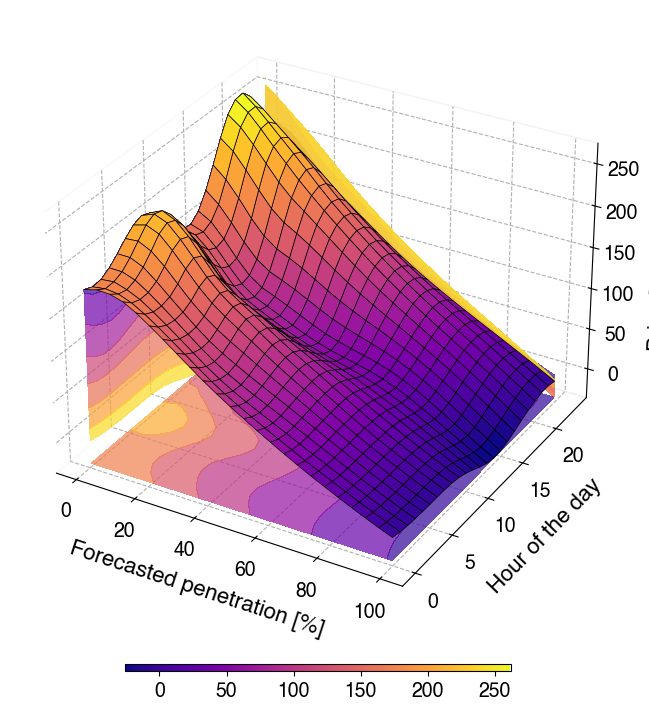

In [6]:
#from utils_mean import *
import matplotlib as mpl
import matplotlib.colors as mcolors

# Set plot aesthetics
mpl.rcParams.update({
    'font.family': 'Helvetica',  # Use Helvetica for clarity
    'axes.labelsize': 16,        # Larger axis labels
    'axes.titlesize': 16,        # Title font size
    'xtick.labelsize': 14,       # X-axis tick label size
    'ytick.labelsize': 14,       # Y-axis tick label size
    'legend.fontsize': 14,       # Legend font size
    'axes.grid': True,           # Enable grid
    'grid.alpha': 0.1,           # Subtle grid lines
    'grid.linestyle': '--',      # Dashed grid lines for a softer look
    'figure.dpi': 300,           # High DPI for high-quality figure
    'savefig.dpi': 300           # High DPI for saving the figure
})

df = pd.read_csv('data/thesis_data.csv')
df = df[df['wind_penetration'] < 100] # outlier check

# Define covariates and response
covariates = ['wind_penetration', 'Hour']
response = 'electricity_price'

# Process data
input_variables, target_variable, scaler = process_data(data=df, covariates=covariates, response=response)

# Fit models
fitting_points, predicted_values = fit_model(features=input_variables, target=target_variable, n_fitting_points=24)

# Plot results
n_grid_points = 24

fitting_points = fitting_points.cpu()  # Transfer to CPU
predicted_values = predicted_values.cpu()  # Transfer to CPU

grid_y, grid_x = np.meshgrid(np.linspace(-1, 1, n_grid_points), np.linspace(-1, 1, n_grid_points))
grid_z = griddata(fitting_points.numpy(), predicted_values.numpy(), (grid_x, grid_y), method='cubic')

original_grid_x, original_grid_y = scaler.inverse_transform(np.column_stack([grid_x.ravel(), grid_y.ravel()])).T
original_grid_x = original_grid_x.reshape(grid_x.shape)
original_grid_y = original_grid_y.reshape(grid_y.shape)

# colors_wind = ["#f0f0f0", "#1f77b4"]  # Light gray to blue
# colors_wind = ["#add8e6", "#1f77b4"]  # Light blue to dark blue
colors_wind = ["#e0ffff", "#1f77b4"]  # Light cyan to bright blue
n_bins = 100  # Number of bins for colormap
# cmap_wind = mcolors.LinearSegmentedColormap.from_list("wind_cmap", colors_wind, N=n_bins)
cmap_wind = 'plasma'
# cmap_wind = 'Blues'

fig = plt.figure(figsize=(8, 8), dpi=100)
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(original_grid_x, original_grid_y, grid_z, cmap=cmap_wind, edgecolor='k', linewidth=.5)
contours = ax.contourf(original_grid_x, original_grid_y, grid_z, zdir='z', offset=np.min(grid_z), cmap=cmap_wind, alpha=0.7)
contours = ax.contourf(original_grid_x, original_grid_y, grid_z, zdir='x', offset=np.min(original_grid_x), cmap=cmap_wind, alpha=0.7)
contours = ax.contourf(original_grid_x, original_grid_y, grid_z, zdir='y', offset=np.max(original_grid_y), cmap=cmap_wind, alpha=0.7)

cbar = fig.colorbar(surface, orientation='horizontal', shrink=0.5, aspect=50, pad=0.05)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_xlabel('Forecasted penetration [%]', labelpad=10)
ax.set_ylabel('Hour of the day', labelpad=10)
ax.set_zlabel('Price [EUR/MWh]', labelpad=10)
# ax.set_zlim(-80, 200)
plt.tight_layout()
#plt.savefig(f'png/LWPR_wind.png',format='png', dpi=600)
plt.show()

In [7]:
# Example: check wind price at ~30% penetration, hour 2:00 and ~50% penetration, hour 2:00

# Map percentages and hour to scaled [-1, 1]
scaled_30 = 2 * (30 / 100) - 1  # because penetration is in [%]
scaled_50 = 2 * (50 / 100) - 1
scaled_hour = 2 * (2 / 23) - 1  # because hour ranges 0–23

# Find the closest grid points
distances_30 = np.sqrt((original_grid_x - 30)**2 + (original_grid_y - 2)**2)
idx_30 = np.unravel_index(np.argmin(distances_30), original_grid_x.shape)
price_30 = grid_z[idx_30]

distances_50 = np.sqrt((original_grid_x - 50)**2 + (original_grid_y - 2)**2)
idx_50 = np.unravel_index(np.argmin(distances_50), original_grid_x.shape)
price_50 = grid_z[idx_50]

# Calculate the approximate gradient between these two points
gradient = (price_50 - price_30) / (50 - 30)

print(f"At 30% penetration, hour 2: predicted price ≈ {price_30:.2f} EUR/MWh")
print(f"At 50% penetration, hour 2: predicted price ≈ {price_50:.2f} EUR/MWh")
print(f"Approx gradient between 30–50% penetration at hour 2: {gradient:.2f} EUR/MWh per % point")

At 30% penetration, hour 2: predicted price ≈ 121.30 EUR/MWh
At 50% penetration, hour 2: predicted price ≈ 81.63 EUR/MWh
Approx gradient between 30–50% penetration at hour 2: -1.98 EUR/MWh per % point
